# Session 3: NFL Sports Data - Sports Reference

Immanuel Williams & Ciera Millard  
2025-07-16

[Download starter .qmd file](03_Extraction_of_Data_NFL_HTML.qmd)

# Session 3: Extracting data via Web Scraping

In the last section, we saw how APIs can provide clean, structured data
directly from a server. However, not all information on the web is
available through a dedicated API. In this section, we’ll pivot to **web
scraping**, a powerful technique for extracting information directly
from the HTML source code of a website that you see in your browser.

Unlike the neat JSON from an API, data on a webpage is often messy and
designed for visual display, not easy analysis. This means web scraping
is inseparable from **data cleaning**. The data we extract will
frequently require us to wrangle it into a tidy, usable format,
providing a great opportunity to practice and develop essential data
manipulation skills.

## Part 1. Goals & Objectives

1.  **Review Important aspects in R:** We are going to spend sometime
    reviewing basic components of the \`tidyverse\` and other related
    tools that are paramount to data cleaning.
2.  **Deconstruct HTML Structure for Scraping:** Identify and understand
    the role of fundamental HTML tags (`<table>`, `<tr>`, `<td>`,
    `<th>`) within a live webpage’s source code to locate target data
    for extraction.
3.  **Extract Tabular Data Using `rvest`:** Use the `rvest` package to
    read the HTML from a URL, select a specific table from the page, and
    convert it into a raw R data frame.
4.  **Perform Advanced Data Tidying and Transformation:** Execute a
    multi-step data cleaning workflow on a messy, scraped data frame
    using packages like `janitor` and `dplyr` to clean column names,
    remove irrelevant rows, and correctly parse data types.
5.  **Appreciate the “Brittleness” of Web Scrapers:** Recognize why web
    scraping scripts can break over time due to changes in a website’s
    layout and understand the importance of writing adaptable and
    well-documented code.

## Part 2. Conceptual Foundation

### 1. Review of Key Functions and Concepts

Of course. Here is a structured guide with concise explanations and
sample data to effectively teach these R concepts for a web scraping
workshop. The goal is to give attendees a clear understanding of what
the code does without getting lost in details.

#### a) Extracting Items with `pluck`

Using the `[[]]` notation to extract information from a list can be hard
to understand, especially teach.

`pluck()` from the `purrr` package is for safely pulling out a single
piece of data from a list or a data frame column that contains lists.

**Fake Data**: Imagine you scraped data and have a list of authors for
each book.

In [ ]:
library(purrr)
library(tibble)

book_lst <- tibble(
  title = c("The Hobbit", "Dune"),
  details = list(
    list(author = "Tolkien", year = 1937),
    list(author = "Herbert", year = 1965)
  )
)

book_lst

**Code Demo**: Let’s “pluck” the author from the first book’s details.

In [ ]:
# Get the 'author' from the first element of the 'details' column
pluck(book_lst, "details", 1, "author")

This is like telling R: go into `book_data`, find the `details` column,
go to its `first` element, and grab the value named `author`.

#### b) Cleaning Data with `janitor`

The `janitor` package is your best friend for cleaning up messy data.

**Fake Data**: Data scraped from a website often has messy column names
and extra empty spaces.

In [ ]:
library(janitor)

messy_df <- data.frame(
  `First Name` = c("gandalf", "frodo", NA),
  `Last Name` = c("the grey", "baggins", NA),
  `AGE` = c("2019", "50", NA)
)

messy_df

Quick Question: Why is this messy?

**Code Demos**:

1.  **`clean_names()`** from the `janitor` package makes column names
    neat and consistent (snake_case).

In [ ]:
cleaned_df <- clean_names(messy_df)         
colnames(cleaned_df)

But still have not taken care of all the issues:

In [ ]:
cleaned_df

1.  **`remove_empty()`** gets rid of empty rows or columns.

In [ ]:
# The third row is empty, so it gets removed     
remove_empty(cleaned_df, which = "rows")     

1.  **`adorn_totals()`** is powerful for quickly adding sums.

In [ ]:
# Let's use a numeric data frame     
sales_df <- data.frame(         
  product = c("A", "B"),         
  q1_sales = c(100, 200),         
  q2_sales = c(150, 250))  %>%  
  adorn_totals(where = "row")     

sales_df

#### c) Simple Renaming with `rename`

The `rename()` function from `dplyr` is the most direct way to rename
one or more specific columns. The pattern is always
**`new_name = old_name`**.

**Fake Data**: Let’s use our cleaned data from before.

In [ ]:
library(dplyr)

cleaned_df

**Code Demo**: Let’s change `age` to `character_age`.

In [ ]:
cleaned_df %>%
  rename(character_age = age)

#### d) Advanced Renaming with `rename_with`

`rename_with()` is for changing many column names at once using a
**pattern**. It’s perfect when you want to apply the same rule to
multiple columns.

**Fake Data**: Imagine your scraped data has a weird prefix on several
columns.

In [ ]:
with_prefix_df <- data.frame(
  `_name` = c("Aragorn", "Legolas"),
  `_race` = c("Human", "Elf"),
  `id` = c(1, 2)
)

**Code Demo**: Let’s remove the leading underscore `_` from every column
that starts with one.

In [ ]:
library(stringr)

with_prefix_df %>%
  rename_with(~ str_replace(., "^_", ""), .cols = starts_with("_")) %>% 
  colnames()

-   `rename_with(...)`: “I want to rename some columns.”
-   `~ str_replace(., "^_", "")`: The rule is to replace a `^` (start of
    the text) followed by `_` with nothing (`""`). The `.` is a
    placeholder for the column name.
-   `.cols = starts_with("_")`: “Only apply this rule to columns that
    start with `_`.”

#### e) Selecting Columns with `!` and `:`

You can use `select()` from `dplyr` to keep or remove columns.

-   `:` (colon) selects a **range of columns**.
-   `!` (bang) **removes** a column.

**Fake Data**:

In [ ]:
character_stats_df <- data.frame(
  name = c("Gimli", "Samwise"),
  race = c("Dwarf", "Hobbit"),
  weapon = c("Axe", "Frying Pan"),
  age = c(139, 33)
)

**Code Demos**:

1.  Select all columns FROM ‘race’ TO ‘weapon’

In [ ]:
character_stats_df %>% 
  select(race:weapon)

1.  Select everything EXCEPT the ‘age’ column

In [ ]:
character_stats_df %>% 
  select(!age)

#### f) Understanding Regular Expressions (`regex`)

A **regular expression** (or regex) is a pattern used to find and match
text. It looks weird, but it’s just a set of rules.

Let’s break down this regex for finding numbers:
`^\\s*-?\\d*\\.?\\d+\\s*$`

| Part     | Meaning                                   | Example Matches |
|:---------|:------------------------------------------|:----------------|
| `^`      | Start of the string                       |                 |
| `\\s*`   | Zero or more whitespace characters (`\s`) | (space)         |
| `-?`     | An optional hyphen (`-`)                  | `-`             |
| `\\d*`   | Zero or more digits (`\d`)                | `123`, \`\`     |
| `\\.?`   | An optional literal dot (\`.\`)           | \`.\`           |
| \`\d+\`  | **One** or more digits (\`\d\`)           | \`45\`, \`6\`   |
| \`\s\*\` | Zero or more whitespace characters        | \` \` (space)   |
| \`\$\`   | End of the string                         |                 |

**In English**: This pattern looks for strings that **start** (`^`),
might have some spaces (`\s*`), might have a minus sign (`-?`), might
have some digits (`\d*`), might have a decimal point (`\.?`), must have
at least one digit (`\d+`), might have more spaces (`\s*`), and then
must **end** (`$`).

This pattern will match `"5"`, `" -10.5 "`, and `".5"` but will **not**
match `"5a"`, `"-$5"`, or `"1.2.3"`.

#### g) `across()` for Mass Changes

`across()` is a super-powerful `dplyr` function that lets you apply the
same operation to **multiple columns at once**. It’s almost always used
inside `mutate()`.

**Fake Data**: Scraped data often reads numbers as text.

In [ ]:
scraped_measurements_df <- data.frame(
  id = c("A", "B", "C"),
  width = c("10.5", "8", "9.1"),
  height = c(" 5.2 ", "-3", "7.7"),
  comment = c("ok", "good", "perfect")
)

**Code Demo**: Let’s convert every column that looks like a number into
an actual numeric type. We’ll use the `regex` from before.

In [ ]:
numeric_scraped_measurements_df <- scraped_measurements_df %>%
  mutate(across(where(~ all(grepl("^\\s*-?\\d*\\.?\\d+\\s*$", .x))), ~ as.numeric(.)))

str(numeric_scraped_measurements_df)

-   `mutate(across(...))`: We are changing columns.

-   `where(~ all(grepl(...)))`: This part **selects the columns**. It
    tests every column (`where`) to see if (`~`) **all** of its values
    match (`grepl`) our numeric `regex` pattern. It finds `width` and
    `height`.

-   `~ as.numeric(.)`: This part is the **action**. It takes the
    selected columns (`.`) and applies the `as.numeric` function to
    them.

#### h) Conditional Logic with `case_when`

`case_when()` is for creating a new column based on a set of `if/then`
rules. It’s much easier to read than nested `ifelse()` statements. The
syntax is **`condition ~ value`**.

**Fake Data**: Let’s use the numeric data we just created.

In [ ]:
numeric_scraped_measurements_df

**Code Demo**: Let’s create a `size_category` based on the `width`
column.

In [ ]:
numeric_scraped_measurements_df %>%
  mutate(
    size_category = case_when(
      width >= 10   ~ "Large",
      width >= 9    ~ "Medium",
      TRUE          ~ "Small"
    )
  )

-   `case_when()` checks each rule in order. The first one that is
    `TRUE` wins.
-   `width >= 10 ~ "Large"`: If width is 10 or more, the value is
    “Large”.
-   `width >= 9 ~ "Medium"`: If not, but width is 9 or more, it’s
    “Medium”.
-   `TRUE ~ "Small"`: This is the catch-all. If none of the above rules
    were met, the value is “Small”. `TRUE` always evaluates to true, so
    it works like an `else` statement.

####———————

#### Q1.

**(Multiple Choice):** After scraping a table, you find that the column
names are messy and contain spaces, like `"First Name"` and
`"Pts/Game"`. Which function from the **`janitor`** package is
specifically designed to standardize these into a clean, usable format
like `first_name` and `pts_per_game`?

1.  `remove_empty()`

2.  `adorn_totals()`

3.  `rename_with()`

4.  `clean_names()`

**Ans Q1.**

1.  **`clean_names()`** is the `janitor` function built specifically for
    this purpose. It automatically converts column names to a consistent
    format (snake_case by default).

####———————

### 2. HTML Concepts

#### a) How HTML Builds a Web Page

To understand web scraping, we first need to see how a web browser reads
HTML code to display a page.

##### i. The Rendered Page (What You See)

This is the final, visual webpage that you interact with in a browser.
It’s designed to be human-readable.

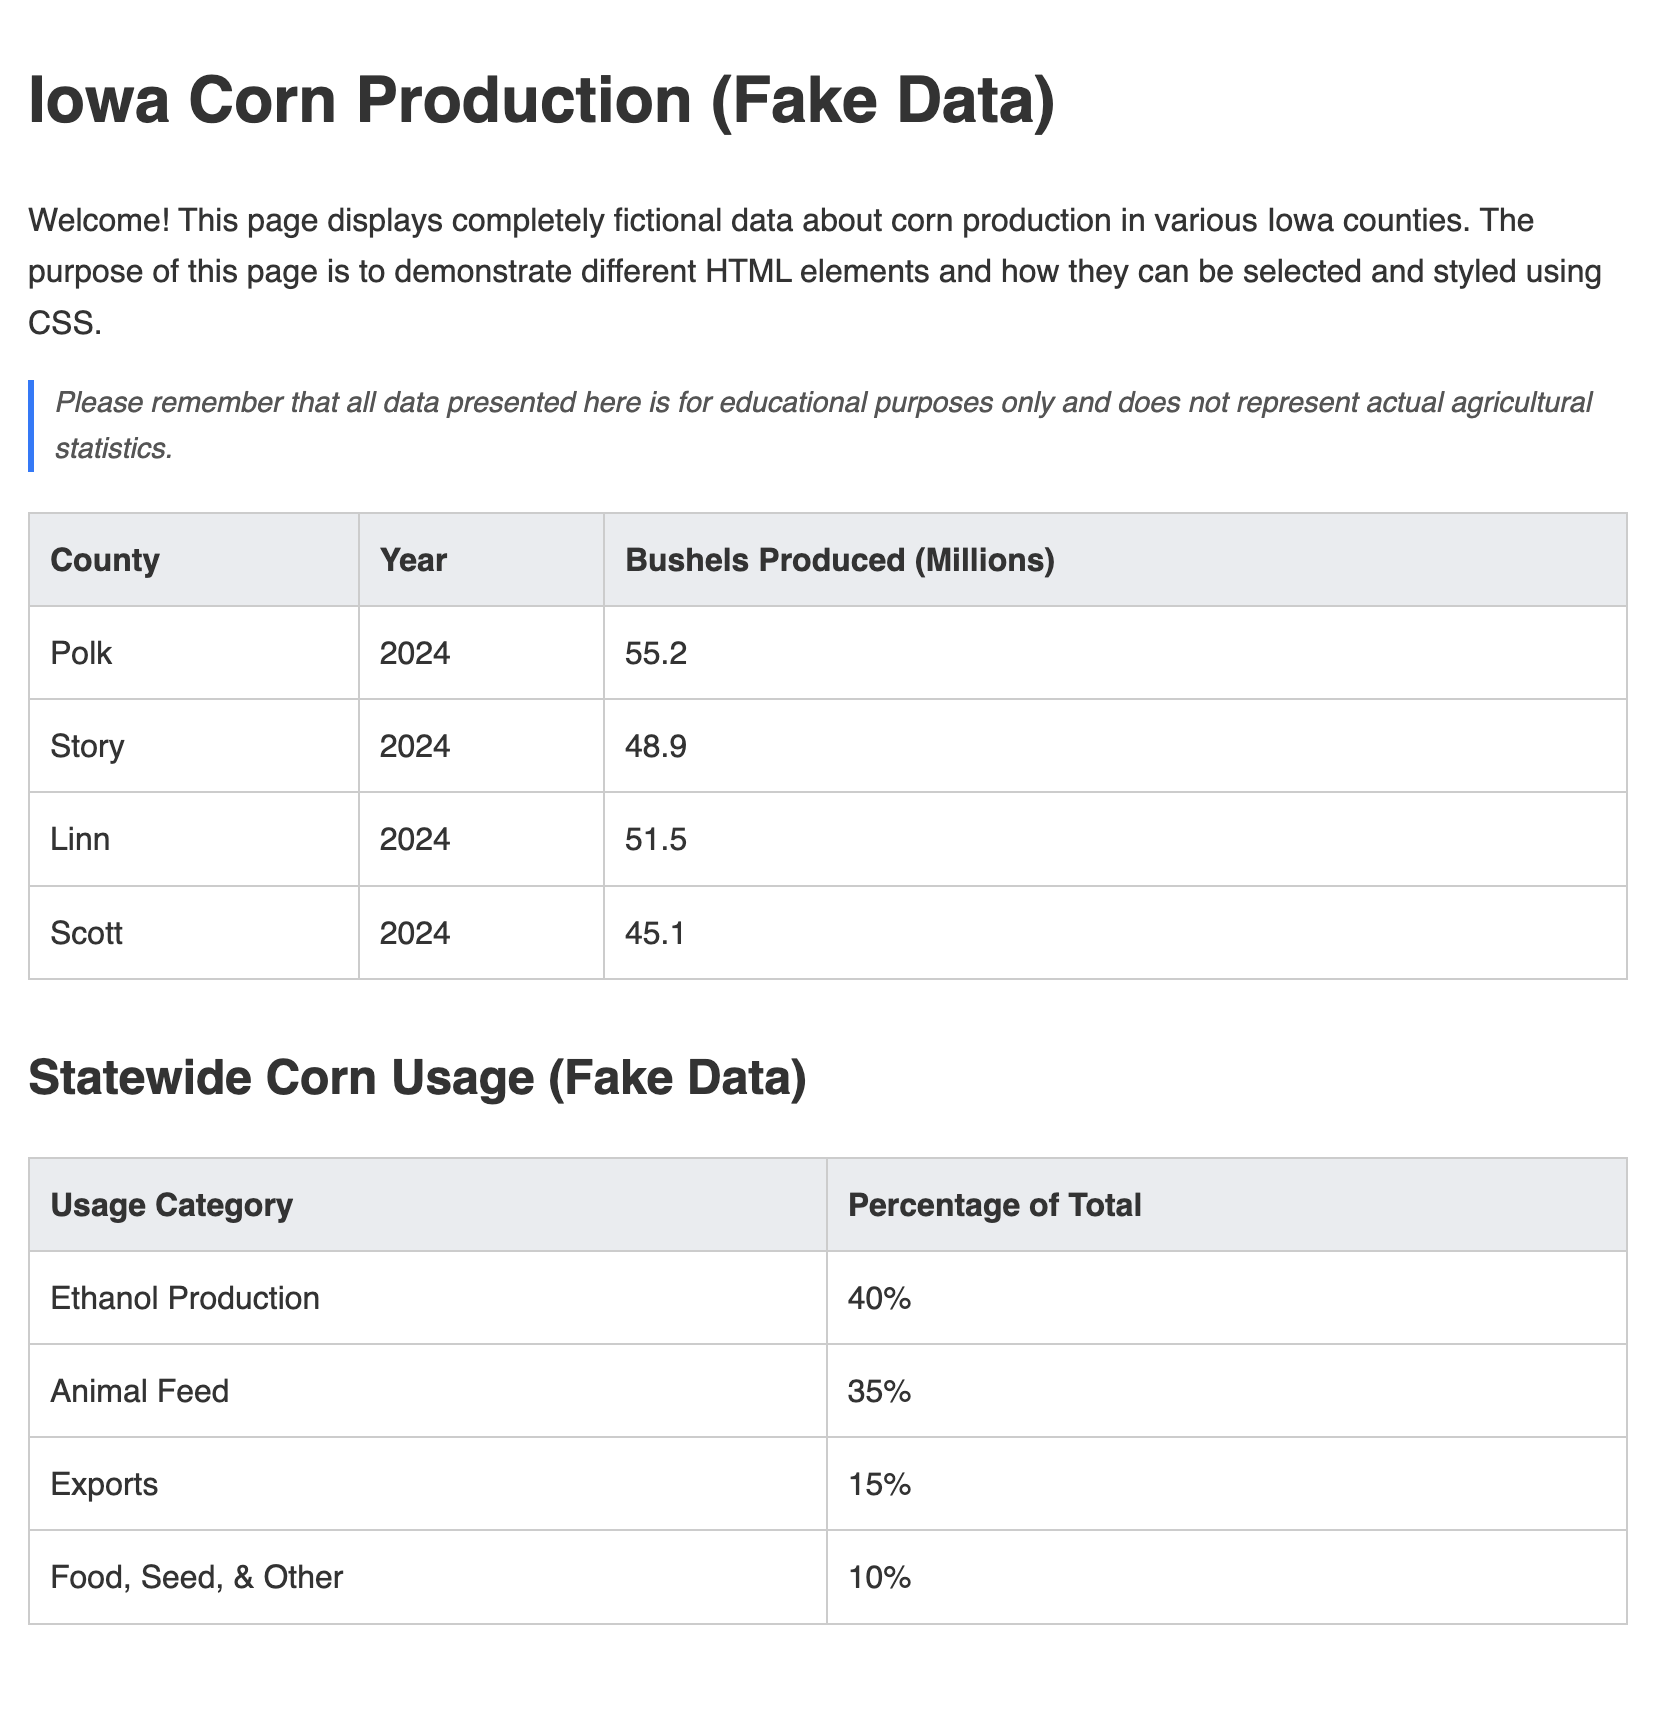

##### ii. The HTML Code (What the Computer Sees)

Behind every webpage is the raw HTML code. This code acts as the
blueprint, telling the browser what content to display and how to
structure it.

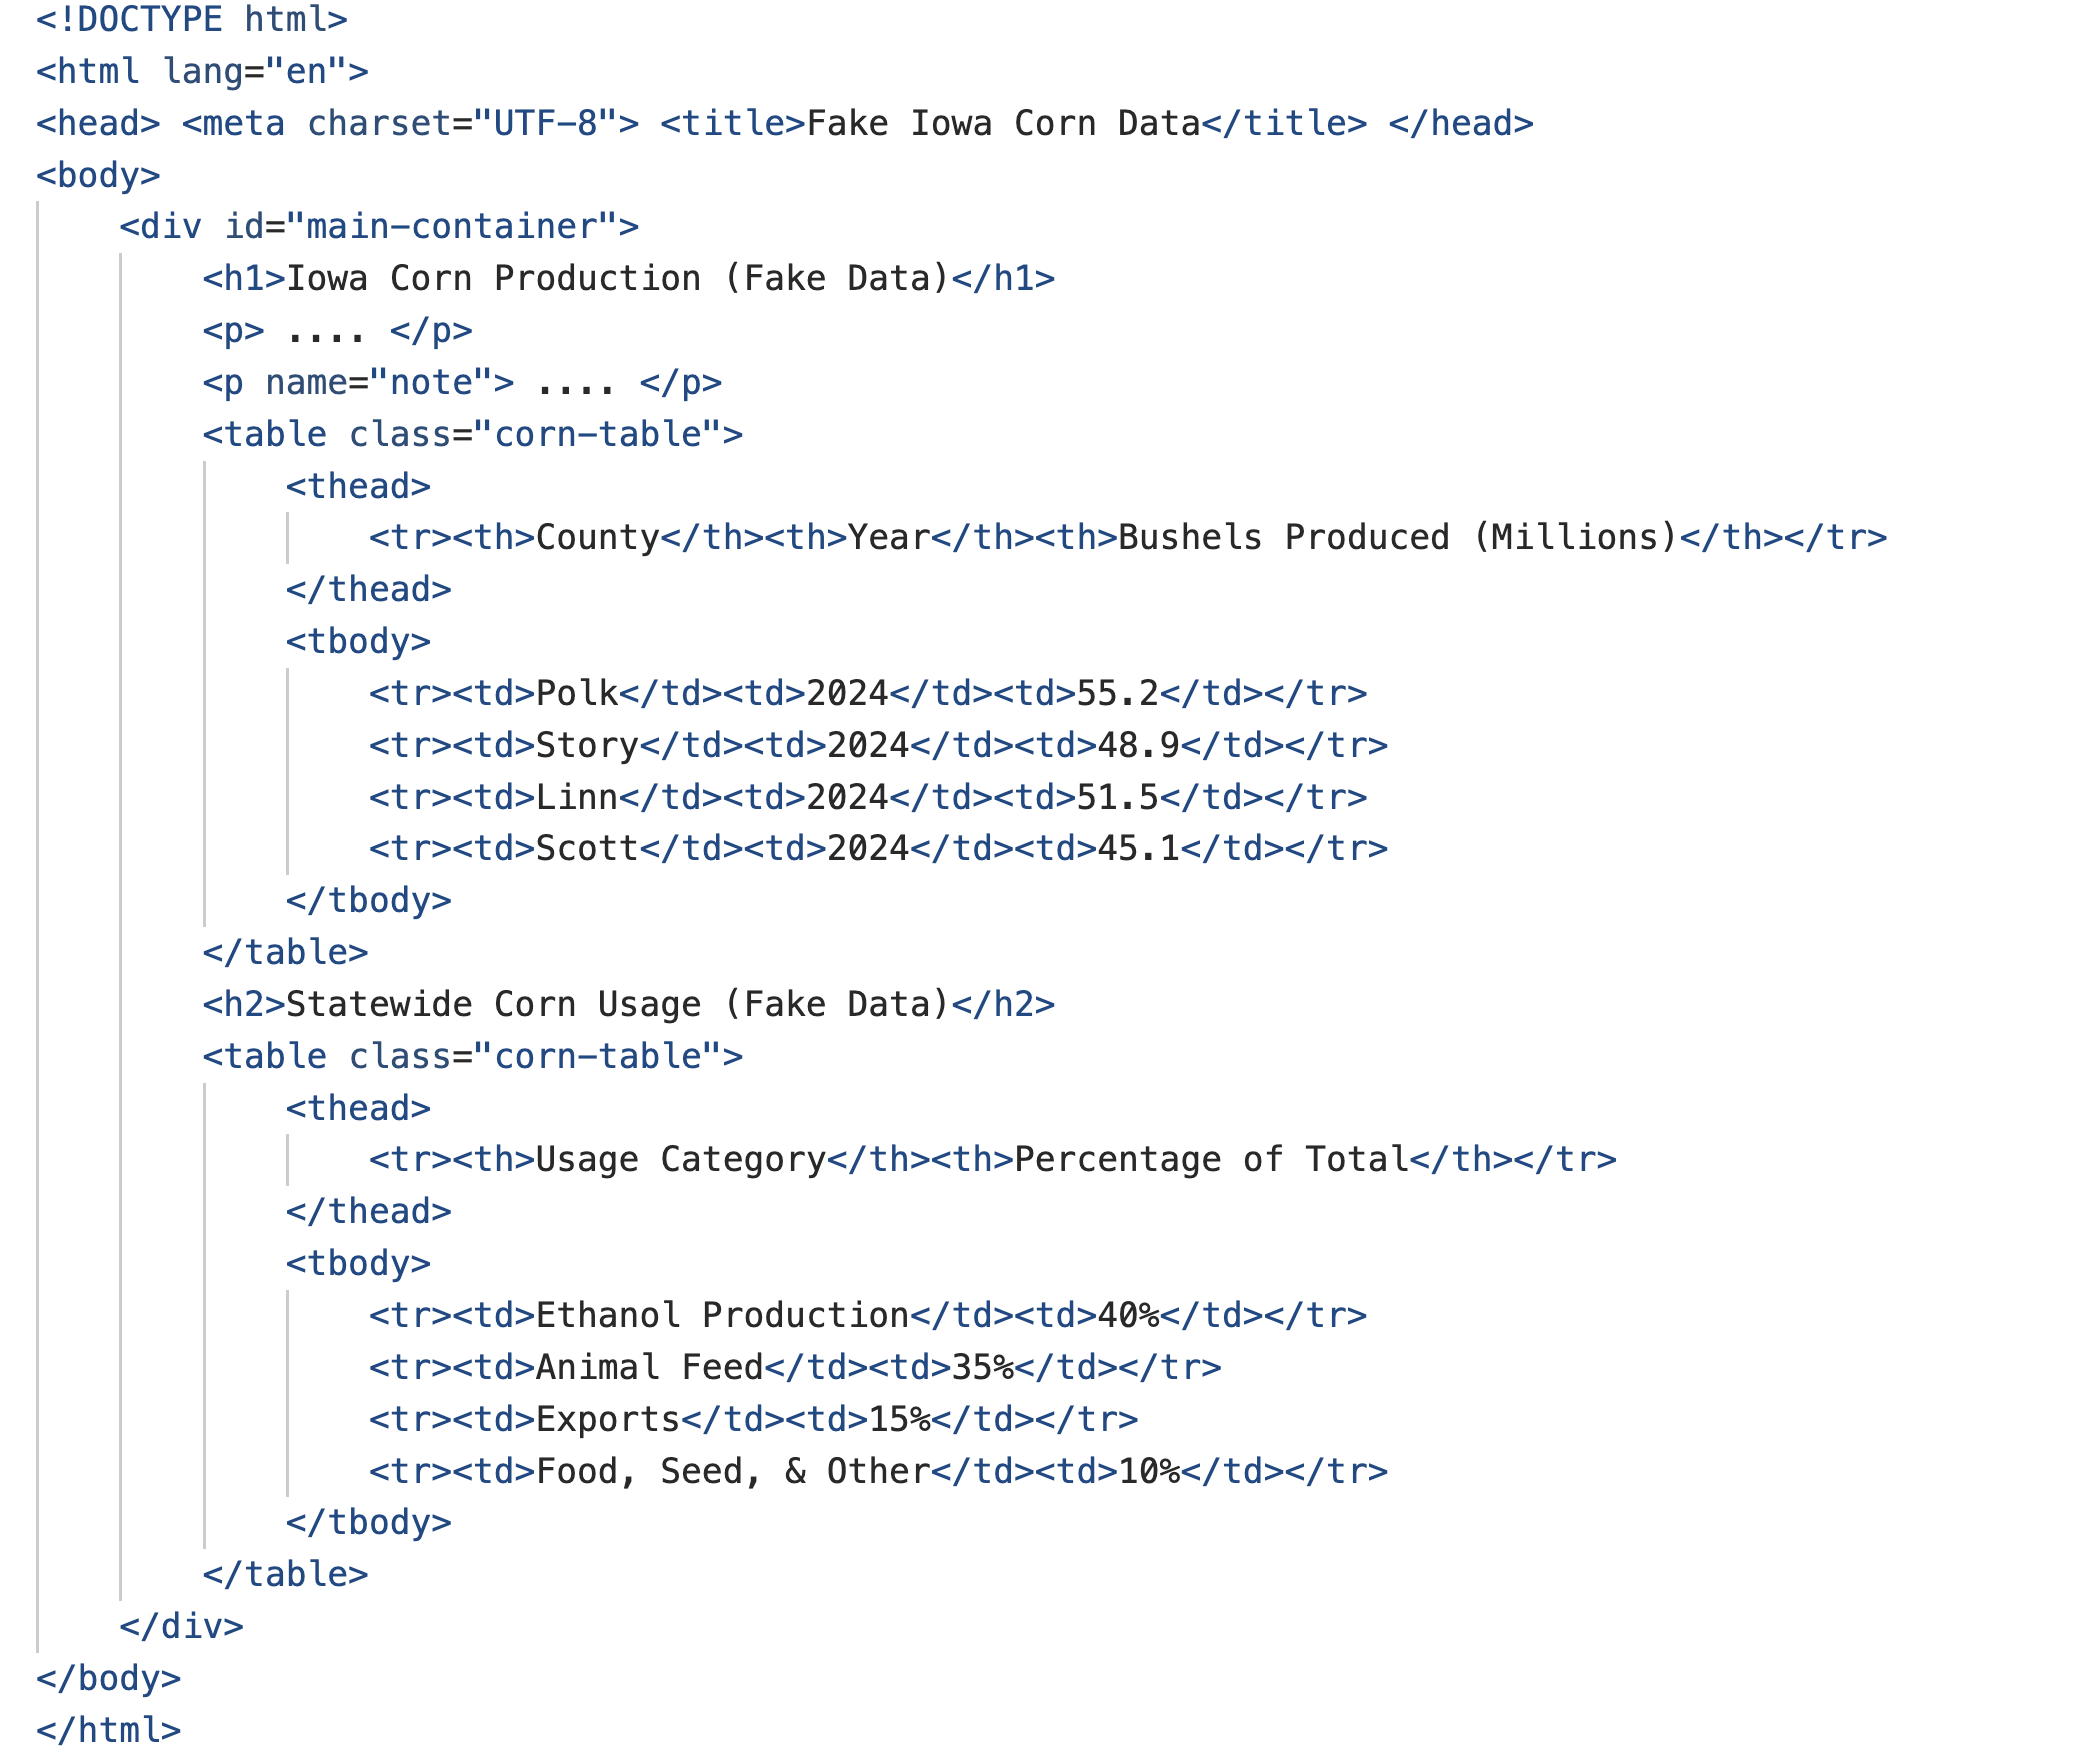

####———————

#### Q2.

**(Open-Ended):** What is the fundamental relationship between the
visual webpage you see rendered in your browser and the HTML source
code? Why must our web scraping tools work with the HTML code?

**Ans Q2.**

The **HTML source code** acts as the blueprint or set of instructions
that tells the browser how to construct the **visual webpage**. Our
scraping tools must work with the HTML code because they cannot “see”
the visual layout; they programmatically read and parse the underlying
structure of the blueprint to find and extract the data elements.

####———————

#### b) Finding a Specific Element: The Table

Let’s focus on a specific part of the page: the data tables.

##### i. The Tables on the Rendered Page

When we scrape, our goal is to extract specific information, like the
data in these two tables.

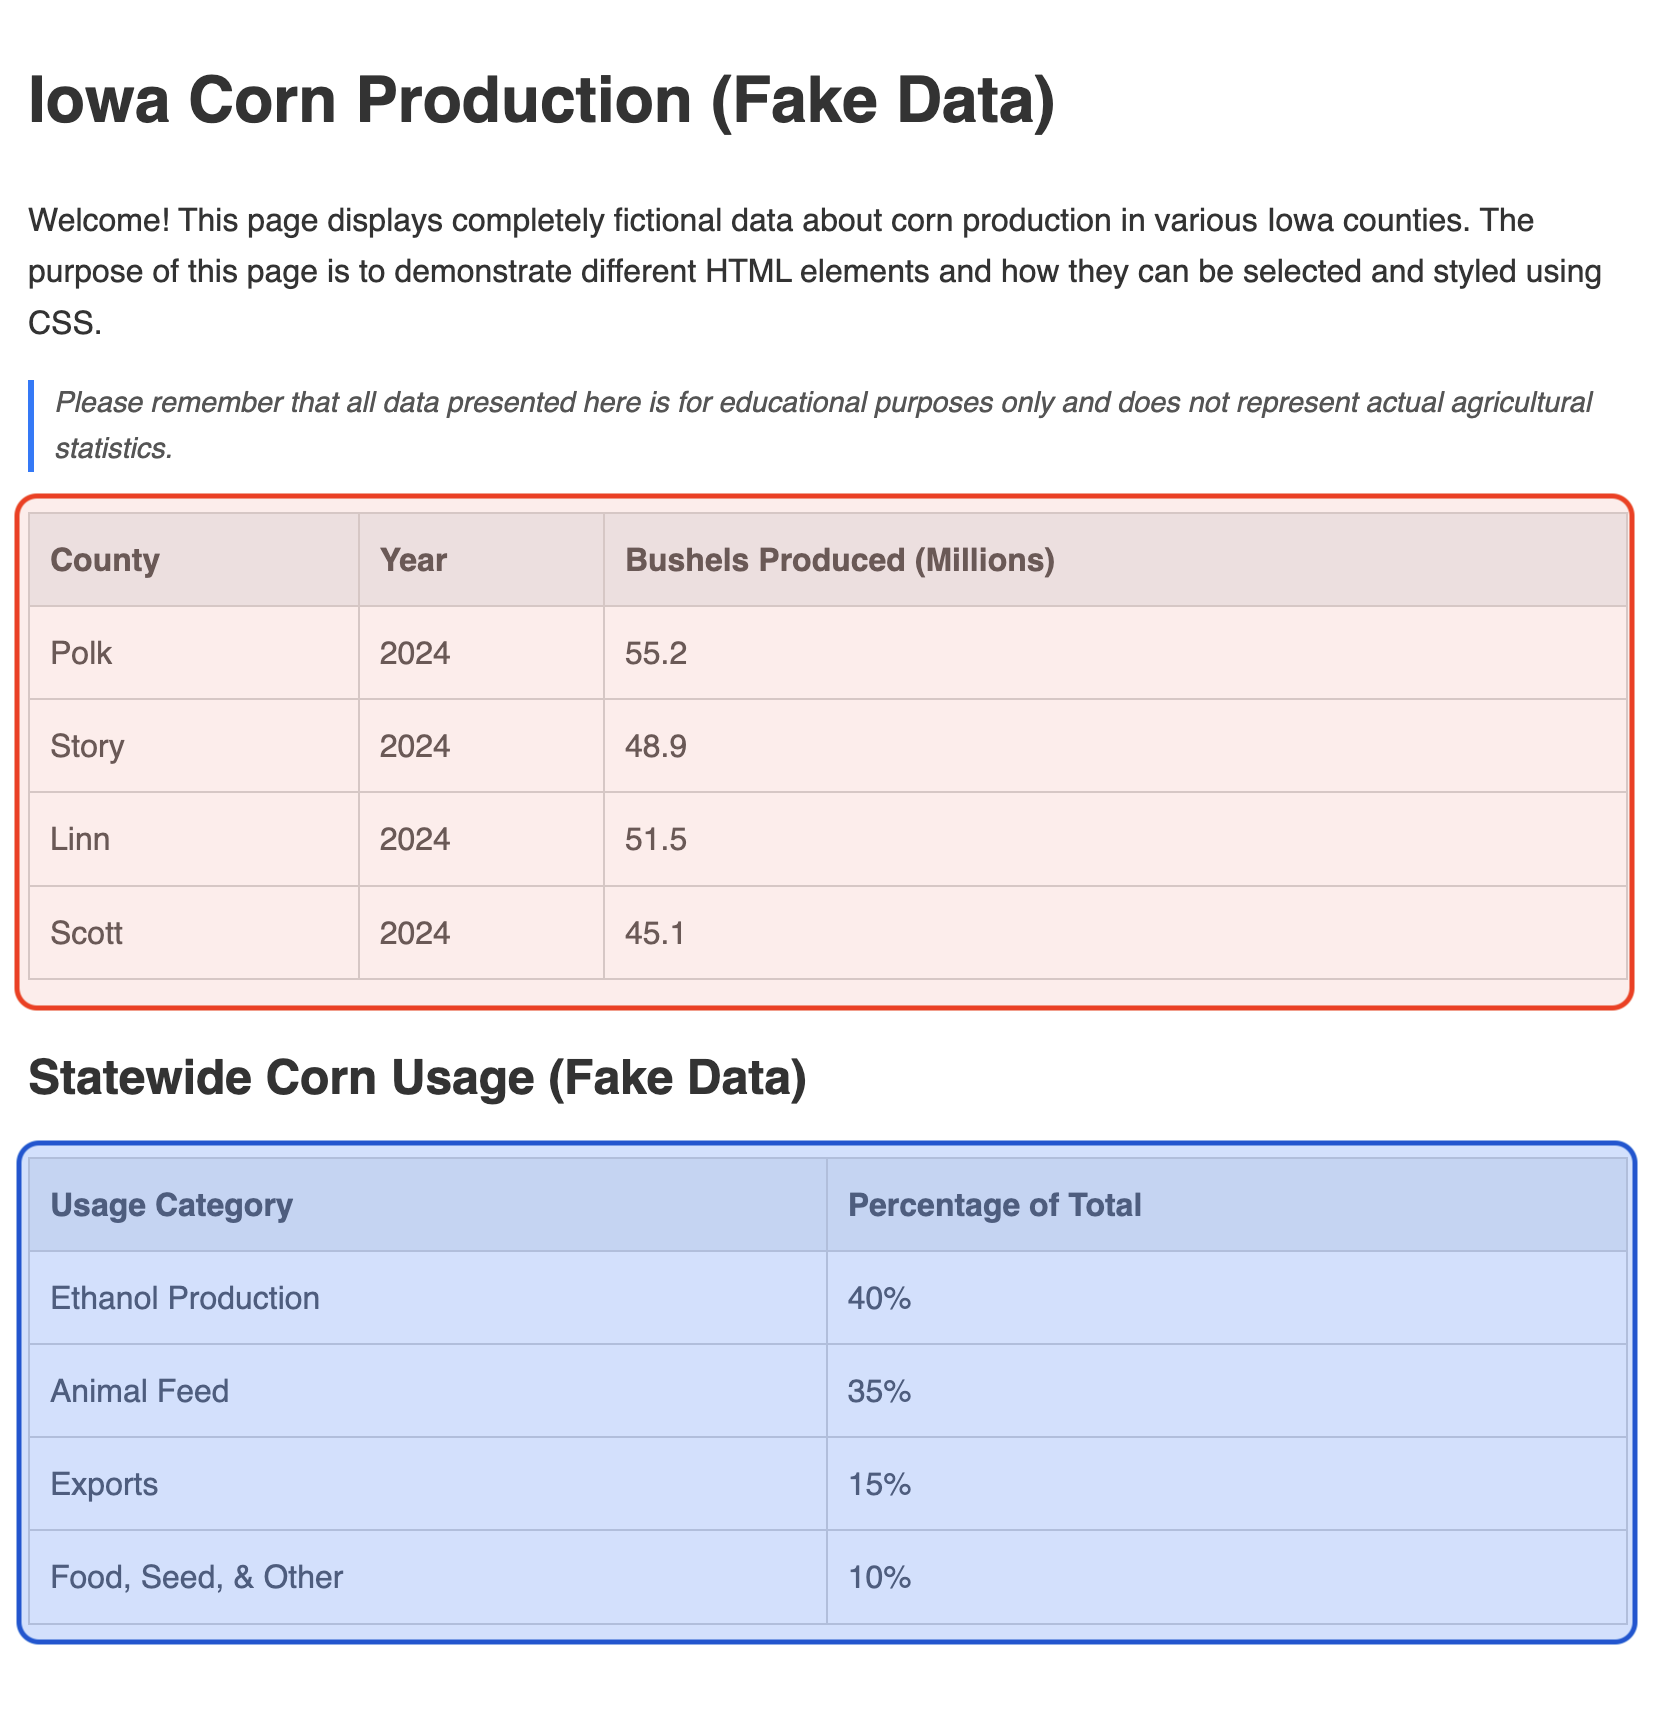

##### ii. The `<table>` Tags in the HTML Code

To extract those tables, we need to find the code that creates them. In
HTML, tables are defined by `<table>` tags, which contain all the data
and structure for a specific table.

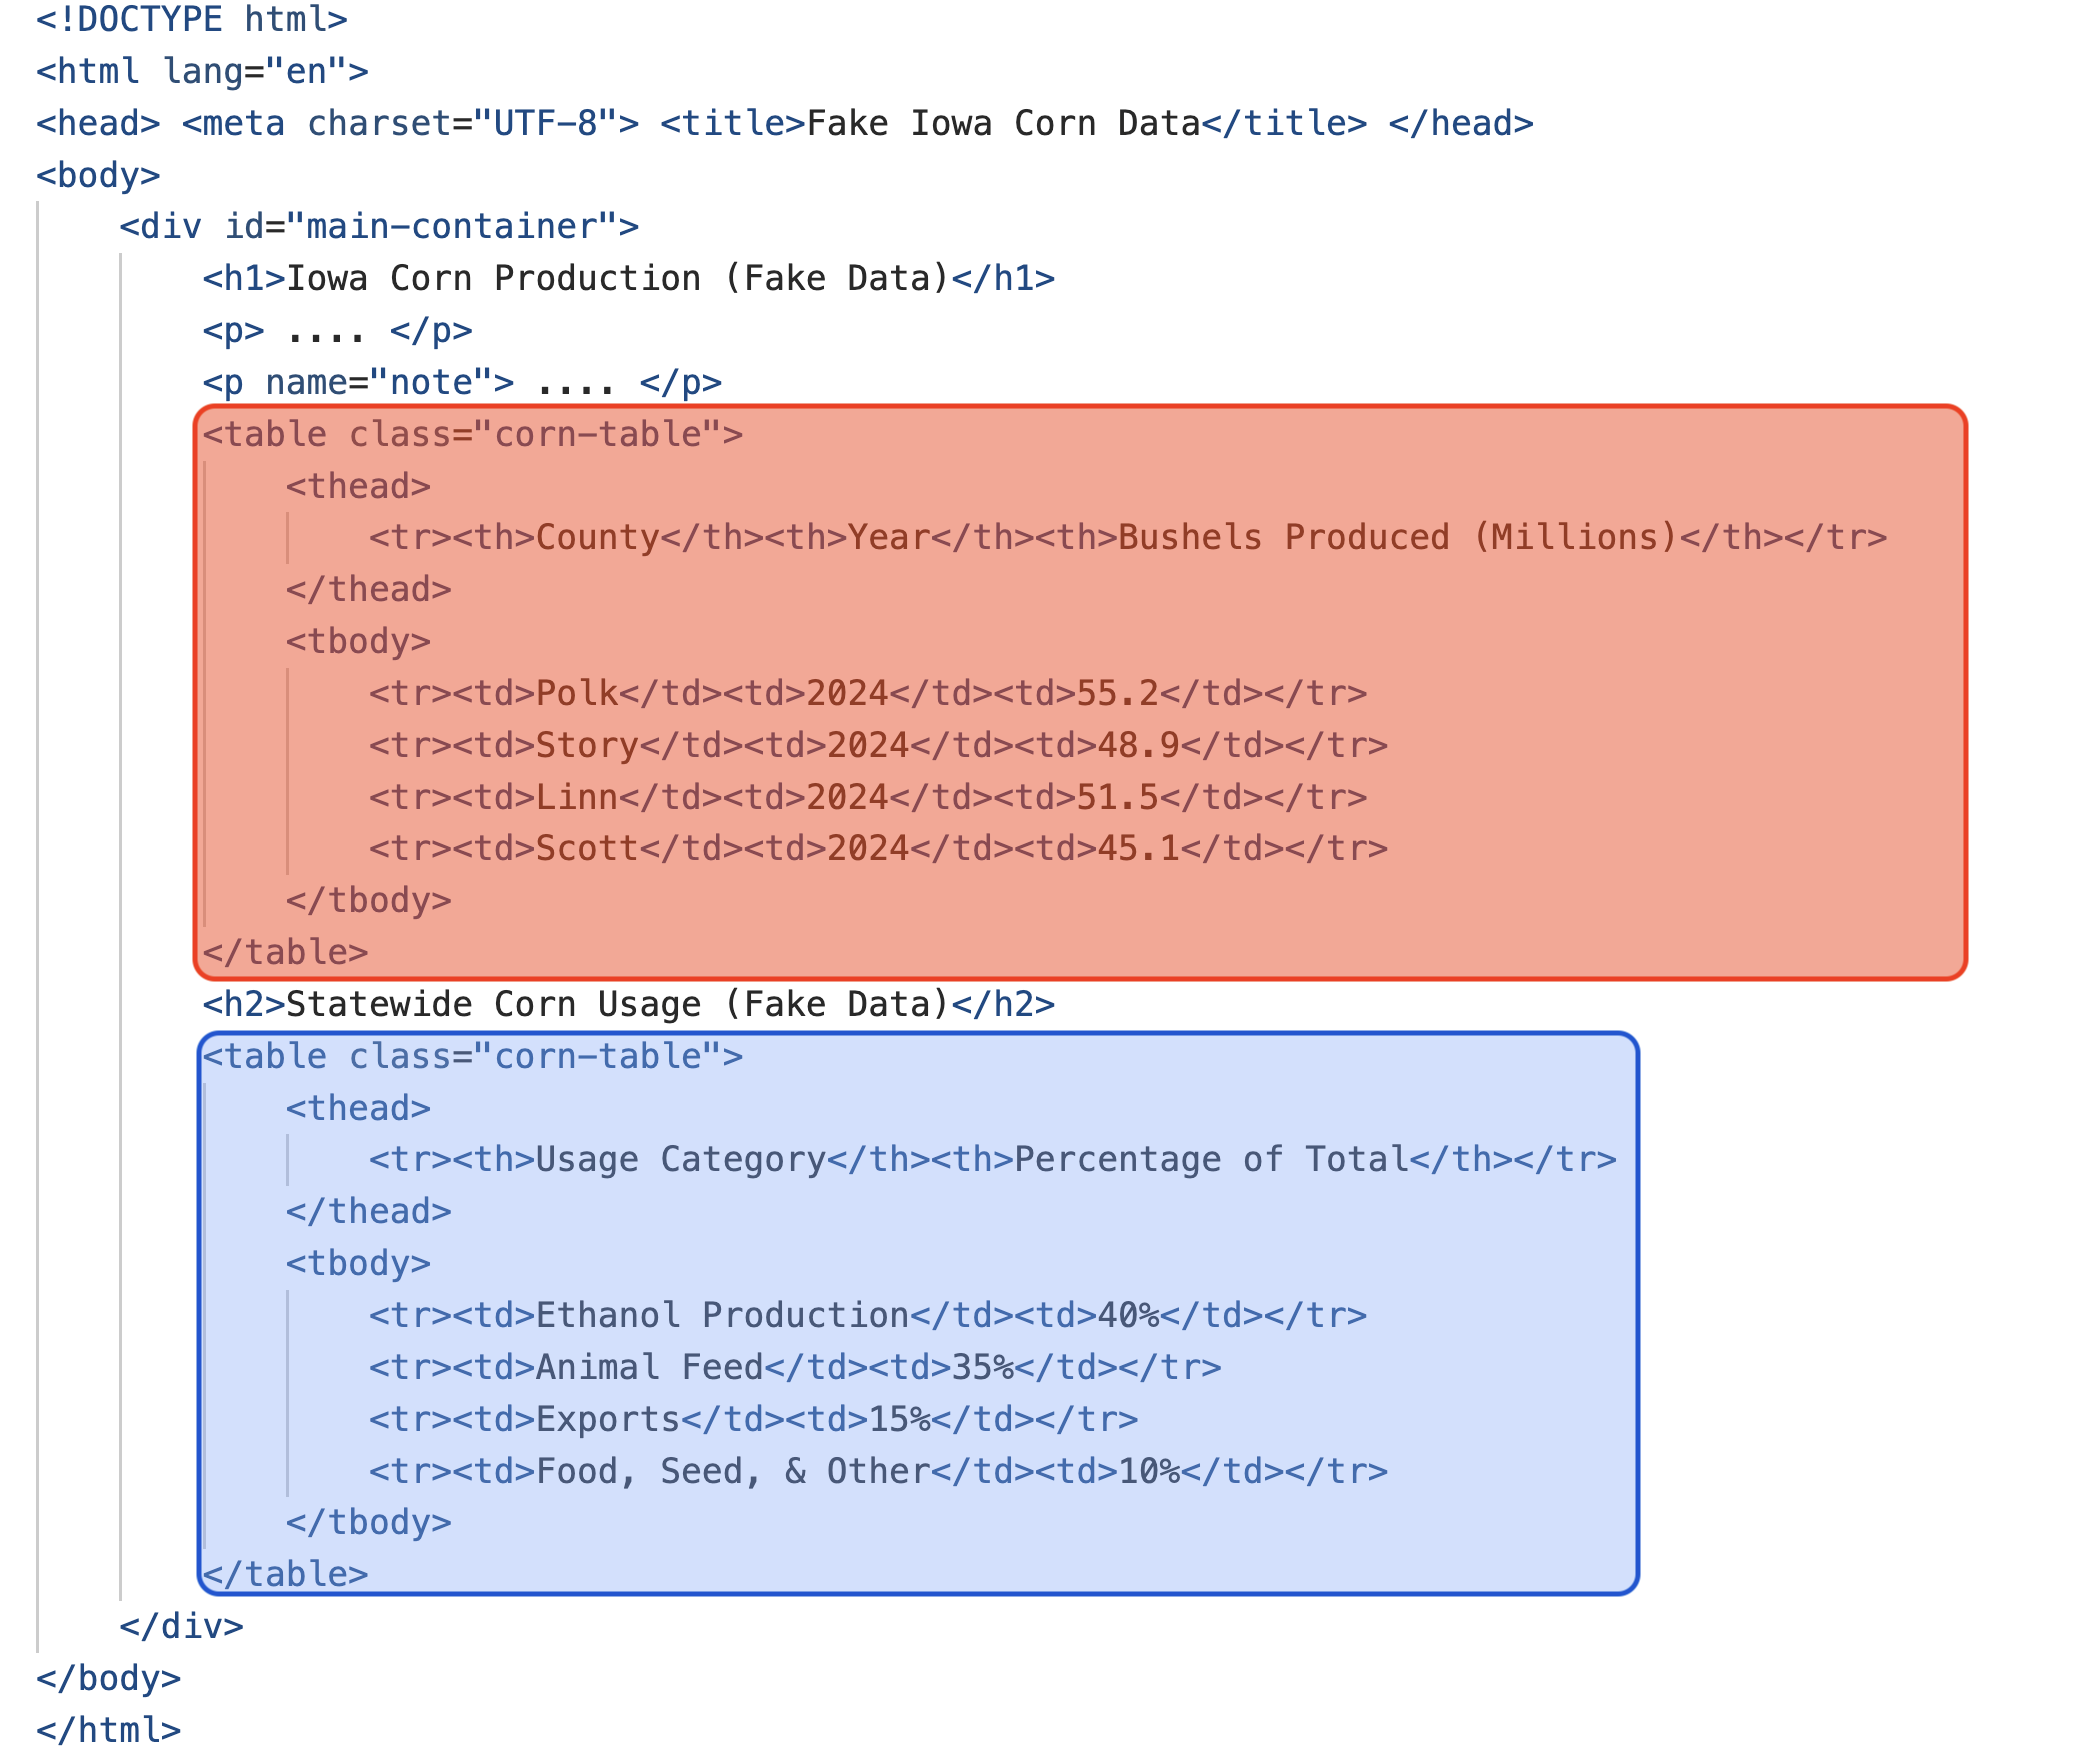

####———————

#### Q3.

**(Discussion):** If a webpage contains multiple tables (e.g., one for
regular-season stats and one for playoff stats), how does `rvest`
initially handle this? How do we then select only the specific table we
want?

**Ans Q3.** Initially, `rvest` doesn’t differentiate between the tables.
When you use `html_table()`, it finds *every* `<table>` tag on the page
and returns them as a **list of data frames**. It’s then our job as the
analyst to inspect that list and use a tool like **`pluck()`** or
bracket notation (`[[...]]`) to select the specific data frame we need
based on its position on the page.

####———————

#### c) Anatomy of an HTML Table

An HTML table is built from a set of nested tags that define its
structure and content.

-   `<table></table>` This tag is the main container that wraps around
    all the content for an entire table.

-   `<thead></thead>` This tag defines the header section of a table,
    where you place the row containing the column titles.

-   `<th></th>` A **t**able **h**eader cell, used for column titles.
    Text inside a `<th>` tag is typically bold and centered by default.

-   `<tr></tr>` A **t**able **r**ow, which groups together all the cells
    (`<th>` or `<td>`) that belong in a single horizontal line.

-   `<td></td>` A **t**able **d**ata cell, which contains the individual
    pieces of data in the table’s body.

####———————

#### Q4.

**(Multiple Choice):** In the anatomy of an HTML table, which tag is
used to define a single **table header cell**, typically used for a
column title?

1.  `<td>`

2.  `<tr>`

3.  `<th>`

4.  `<thead>`

**Ans Q4.** c) **`<th>`** stands for **t**able **h**eader. It is used to
define the cells that act as titles for the columns.

####———————

### 3. Desired `rvest` functions

#### a): Reading the HTML File

First, we load our libraries and read the HTML file into an R object.
This step remains the same.

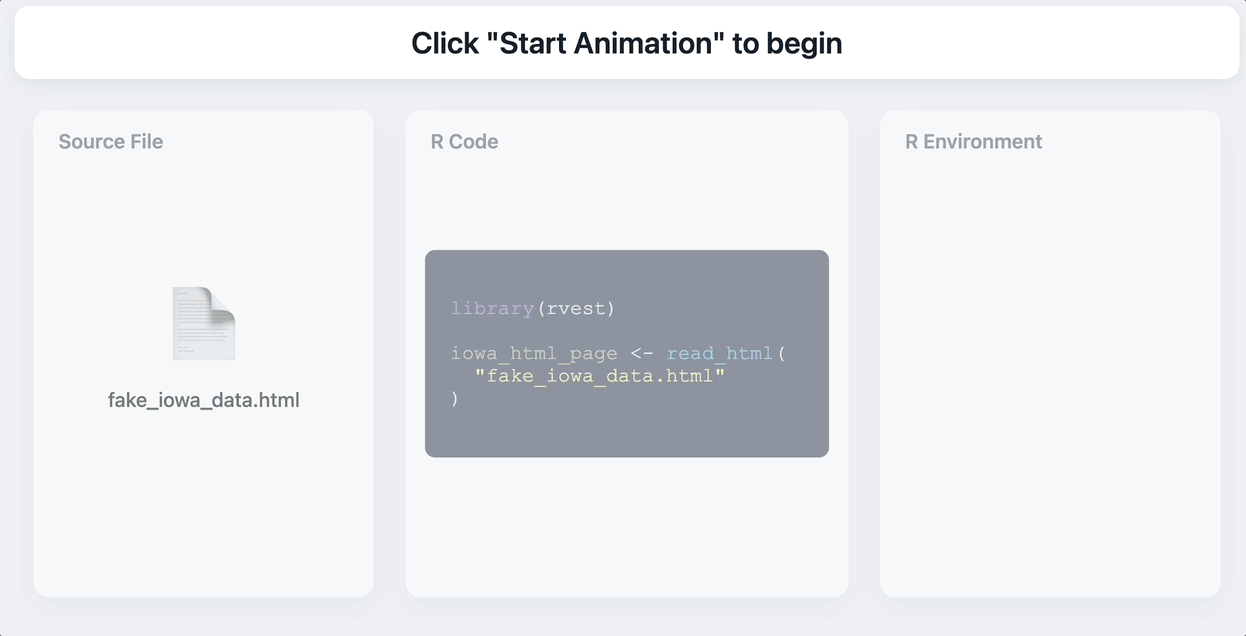

Let’s do it!

In [ ]:
## EMPTY VERSION
# library(_____)
# library(_____)
# library(_____)
# 
# 
# # Read the local HTML file into an R object
# iowa_html_page <-  _____("sessions","session_3","fake_iowa_data.html") %>% 
#   read_*()

In [ ]:
## FILLED VERSION
library(rvest)
library(purrr)
library(here)


# Read the local HTML file into an R object
iowa_html_page <-  here("sessions","session_3","fake_iowa_data.html") %>% 
  read_html()

#### b) Extracting the First Table with `pluck()`

Instead of using `[[1]]`, we can pipe the output of `html_table()`
directly into `pluck()`. We tell `pluck()` to retrieve the **first**
element from the list of tables.

In [ ]:
## EMPTY VERSION
## Use pluck() to get the first table from the list
# usage_df <- iowa_html_page %>% 
#   html_*() %>% 
#   _____(____)
# 
# usage_df

In [ ]:
## FILLED VERSION
## Use pluck() to get the first table from the list
production_df <- iowa_html_page  %>% 
  html_table() %>% 
  pluck(1)

print(production_df)

#### c) Extracting the Second Table with `pluck()`

We can use the exact same process to get the second table. We simply
change the index in `pluck()` from `1` to `2` to retrieve the **second**
element from the list.

In [ ]:
## EMPTY VERSION
## Use pluck() to get the second table
# usage_df <- iowa_html_page %>% 
#   html_*() %>% 
#   _____(____)
# 
# usage_df

In [ ]:
## FILLED VERSION
## Use pluck() to get the second table
usage_df <- iowa_html_page %>% 
  html_table() %>% 
  pluck(2)

print(usage_df)

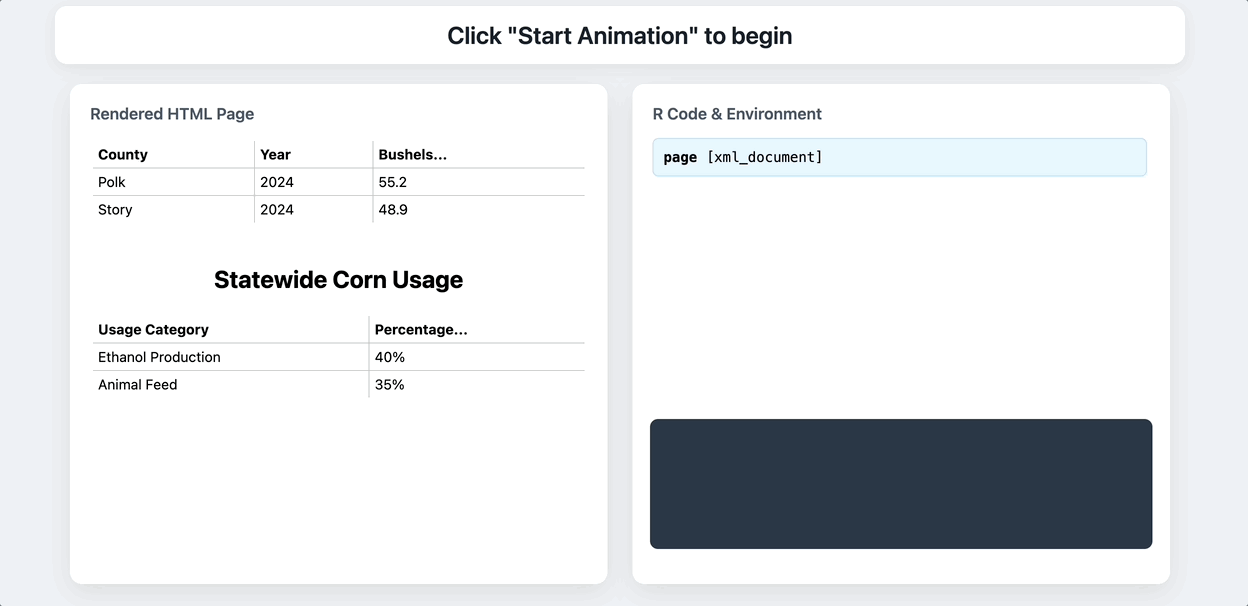

####———————

#### Q5.

**(Open-Ended):** Why does the `html_table()` function in `rvest` return
a *list* of data frames instead of just a single data frame? How does
this make `pluck()` a particularly useful function?

**Ans Q5.** `html_table()` returns a list because a single webpage can
contain many different `<table>` elements, and the function extracts all
of them. `pluck()` is useful because it provides a safe and readable way
to pull a single item (the specific data frame we want) out of that list
by its position (e.g., `pluck(2)` for the second table).

####———————

### 4. Extract NFL Data

Let’s go to this html page. \[HUGE!!!!!!, Always go!\]

[The Best Team in the
NFL](https://www.pro-football-reference.com/teams/was/2023.htm#games)

Our desired table is the 2023 Regular Season Table for the Washington
Commanders, which is the second table on the webpage.

<figure>
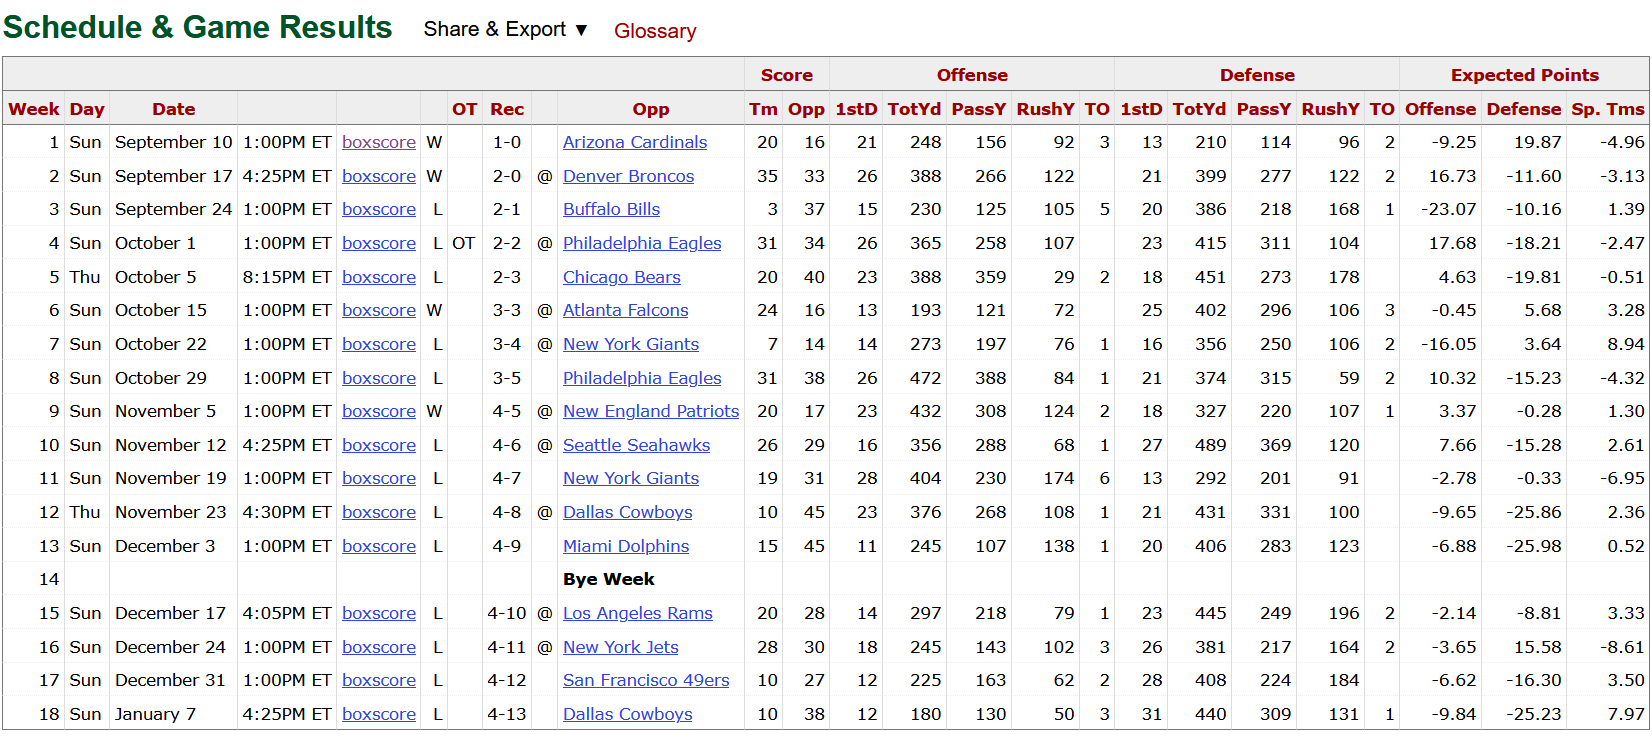
<figcaption aria-hidden="true">This is the table we are
after</figcaption>
</figure>

#### a) Step 1: Retrieve the Game Data

First, we define our parameters (team and year), build the full URL,
read the HTML from the page, and then use `rvest` and `purrr` to extract
the specific table containing the game data we want.

In [ ]:
## EMPTY VERSION
# library(httr2)
# library(rvest)
# library(glue)
# library(purrr)
# 
# # Define team and year
# team_name <- "____"
# year <- ____
# 
# # Construct full URL
# generic_url <- glue("https://www.pro-football-reference.com/teams/{____}/{____}.htm#all_games")
# 
# # Read HTML page and extract tables
# webpage <- read_html(____)
# web_tables <- html_table(____)
# 
# # Pluck the second table (regular season games)
# game_table <- pluck(____, ____)

In [ ]:
## FILLED VERSION
library(httr2)
library(rvest)
library(glue)
library(purrr)

# Define team and year
team_name <- "was"
year <- 2023

# Construct full URL
generic_url <- glue("https://www.pro-football-reference.com/teams/{team_name}/{year}.htm#all_games")

# Read HTML page and extract tables
webpage <- read_html(generic_url)
web_dfs <- html_table(webpage)

# Pluck the second table (regular season games)
game_df <- pluck(web_dfs, 2)

Look at the column names

#### b) Step 2: Clean the Column Headers

Scraped tables often have messy headers. The first row of this table
contains the real column names. We will extract that row, set it as the
new headers, remove the now-redundant first row, and finally use the
**`janitor`** package to standardize the names into a clean format.

**Note:** Sometimes we have to refer to base R syntax (like `colnames()`
and `[-1,]`) because modern `tidyverse` methods may not be the most
direct tool for a specific, low-level task like this.

\[\[REALLY SLOW\]\]

In [ ]:
## EMPTY VERSION


## Use first row as column names
# firstrow_names <- ____[1, ] %>% 
#   unlist() %>% 
#   as.character()

In [ ]:
## EMPTY VERSION
## Assign as column names
# colnames(____) <- ____

In [ ]:
## EMPTY VERSION
## Remove the first row and clean names
# table_1 <- ____[-1, ]
# table_2 <- clean__names(____)

In [ ]:
## FILLED VERSION
## Use first row as column names
firstrow_names <- game_df[1, ] %>% 
  unlist() %>% 
  as.character()

In [ ]:
## FILLED VERSION
## Assign as column names
colnames(game_df) <- firstrow_names

In [ ]:
## FILLED VERSION
## Remove the first row and clean names
df_1 <- game_df[-1, ]
df_2 <- clean_names(df_1)

------------------------------------------------------------------------

#### c) Step 3: Tidy and Transform the Data

The final step is to reshape the data into a truly usable format. This
involves renaming poorly named columns, removing irrelevant columns and
bye weeks, converting columns that look like numbers from text to
numeric, and correctly setting categorical variables (`factors`).

In [ ]:
## EMPTY VERSION
# library(dplyr)
# library(stringr)
# 
## Rename, select, and filter
# table_4 <- table_2 %>% 
#   rename(
#     result = ____,
#     game_location = ____
#   ) %>% 
#   select(!(____:____)) %>% 
#   filter(opp != "____")

In [ ]:
## EMPTY VERSION
## Convert types
# table_6 <- table_4 %>%  
#   mutate(across(where(~ all(grepl("^\\s*-?\\d*\\.?\\d+\\s*$", .x))), ~ as.numeric(.))) %>% 
#   mutate(
#     result = as.factor(____),
#     game_location = case_when(
#       game_location == "@" ~ "____",
#       game_location == "" ~ "____",
#       TRUE ~ ____
#     ) %>% as.factor()
#   )

In [ ]:
## EMPTY VERSION
## Final column name cleanup
# final_games_df <- table_6 %>% 
#   rename_with(~ str_replace(., "^_", ""), .cols = starts_with("____"))

In [ ]:
## FILLED VERSION
library(dplyr)
library(stringr)

In [ ]:
## FILLED VERSION
# Rename, select, and filter
df_3 <- df_2 %>% 
  rename(
    result = x_3,
    game_location = x_4
  ) %>% 
  select(!(x:x_2)) %>% 
  filter(opp != "Bye Week")

In [ ]:
## FILLED VERSION
# Convert types
df_4 <- df_3 %>%  
  mutate(across(where(~ all(grepl("^\\s*-?\\d*\\.?\\d+\\s*$", .x))), ~ as.numeric(.))) %>% 
  mutate(
    result = as.factor(result),
    game_location = case_when(
      game_location == "@" ~ "away",
      game_location == "" ~ "home",
      TRUE ~ game_location
    ) %>%  as.factor()
  )

# Final column name cleanup
final_games_df <- df_4 %>% 
  rename_with(~ str_replace(., "^_", ""), .cols = starts_with("_"))

####———————

#### Q6.

**(Discussion):** Compare the multi-step cleaning process for the
scraped NFL table with the process for the OpenWeather API data in
Session 2. What does this difference demonstrate about the “data
cleaning tax” associated with web scraping? 💸

**Ans Q6.**

The API data was mostly clean and structured, requiring minimal
wrangling. In contrast, the scraped NFL data was messy and required many
steps: fixing headers, removing empty rows, renaming columns, filtering
out irrelevant rows like “Bye Week,” and converting data types. This
demonstrates that the **“data cleaning tax” is much higher for web
scraping**. You gain the flexibility to get data from almost any
website, but you often pay for it with the significant time and effort
required to clean the data into a usable format.

####———————

## Part 3. Hands on Activities

**GENERAL INSRUCTIONS**

*Read the following instructions and complete the activity*

In this activity, we will perform a more advanced web scraping task. We
will extract the complete historical season data for the Iowa State
Cyclones, clean up the messy table, and create a visualization showing
the team’s number of wins per year throughout its history.

#### Hands Activity 1: Scrape Historical Season Data

Our first step is to use **`rvest`** to pull the main history table from
the Iowa State Cyclones page on Sports-Reference. This table is more
complex than our previous examples because it contains repeating header
rows inside its body that we will need to clean up later. We will use
the table’s unique CSS ID (`#history`) to select it precisely.

In [ ]:
## EMPTY VERSION
## Load necessary libraries
# library(rvest)
# library(dplyr)
# 
# # Define the URL for the Iowa State football history page
# url <- "____"
# 
# # Read the HTML and select the table by its ID
# raw_history_df <- read_html(____) %>% 
#   html_element("____") %>% 
#   html_table()
# 
# # View the first few rows to see the raw data
# head(raw_history_df)

In [ ]:
## FILLED VERSION
## Load necessary libraries
library(rvest)
library(dplyr)
library(purrr)

## Define the URL for the Iowa State football history page
url <- "https://www.sports-reference.com/cfb/schools/iowa-state/"

## Read the HTML and select the table by its ID
raw_history_df <- read_html(url) %>% 
  html_table() %>% 
  pluck(1)
  

# #View the first few rows to see the raw data
head(raw_history_df)

What is wrong with this data frame?

#### Hands Activity 2: Clean and Prepare the Data

The raw data we scraped is not yet ready for analysis. We need to
perform two key cleaning steps. First, we’ll remove the repeating header
rows, which we can identify because their “Year” column is not a number.
Second, we’ll convert the columns for year, wins (`W`), and losses (`L`)
into a numeric format so we can use them in our plot.

In [ ]:
## EMPTY VERSION
## Use first row as column names
# firstrow_names <- ____[1, ] %>% 
#   ____() %>% 
#   ____()

In [ ]:
## EMPTY VERSION
## Assign as column names
# ____(raw_history_df) <- ____

In [ ]:
## EMPTY VERSION
# library(____)
# ## Remove the first row and clean names
# history_df <- raw_history_df %>% 
#   ____() %>% # Clean column names first
#   filter(____ != "Rk" ) %>% 
#   mutate(across(where(~ all(grepl("^\\s*-?\\d*\\.?\\d+\\s*$", .x))), ~ ____(.))) # Convert columns to numeric

In [ ]:
## FILLED VERSION
## Use first row as column names
firstrow_names <- raw_history_df[1, ] %>% 
  unlist() %>% 
  as.character()

In [ ]:
## FILLED VERSION
## Assign as column names
colnames(raw_history_df) <- firstrow_names

In [ ]:
## FILLED VERSION
library(janitor)
## Remove the first row and clean names
history_df <- raw_history_df %>% 
  clean_names() %>% # Clean column names first
  filter(rk != "Rk" ) %>% 
  mutate(across(where(~ all(grepl("^\\s*-?\\d*\\.?\\d+\\s*$", .x))), ~ as.numeric(.)))  # Convert columns to numeric

#### Hands Activity 3: Visualize Wins Over Time

Now that our data is clean and properly formatted, we can create a
visualization. We will use **`ggplot2`** to plot the number of wins
(`w`) for each year in the dataset. This line chart will give us a clear
view of the football program’s performance over its entire history.

In [ ]:
## EMPTY VERSION
## Load ggplot2 for plotting
# library(ggplot2)
# 
## Create a line chart of wins per year
# ggplot(data = ____, aes(x = ____, y = ____)) +
#   geom_line(color = "#C8102E", size = 1) +
#   geom_point(color = "#F1BE48", size = 3)) +
#   labs(
#     title = "Iowa State Football Wins Per Season",
#     subtitle = "Data scraped from Sports-Reference.com",
#     x = "Season Year",
#     y = "Number of Wins"
#   ) +
#   theme_minimal() +
#   theme(plot.title = element_text(hjust = 0.5),
#         plot.subtitle = element_text(hjust = 0.5))

In [ ]:
## FILLED VERSION
## Load ggplot2 for plotting
library(ggplot2)

## Create a line chart of wins per year
ggplot(data = history_df, aes(x = year, y = w)) +
  geom_line(color = "#C8102E", size = 1) +
  geom_point(color = "#F1BE48", size = 3) +
  labs(
    title = "Iowa State Football Wins Per Season",
    subtitle = "Data scraped from Sports-Reference.com",
    x = "Season Year",
    y = "Number of Wins"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5))

## Part 4. Reflection

1.  This session described web scrapers as being **“brittle.”** Based on
    the NFL example, what do you think this means? What could cause your
    working script to fail a month from now, even without changing your
    code?

2.  Now that you have experience with both methods, describe a scenario
    where you might choose to **scrape a website** even if a related
    **API was available**. (Hint: Think about cost, API rate limits, or
    the specific data available).

3.  It’s often said that data science is 80% data cleaning and 20%
    analysis. How did the NFL scraping example in this session **support
    or challenge** that idea for you?

4.  Web scraping, especially at a large scale, can put a heavy load on a
    website’s server. What are some **“good citizen”** practices you
    should follow when scraping a site to be respectful and avoid
    getting your IP address blocked?